### Compare theoretical and ground state energy at unit filling

In [27]:
import numpy as np
import bisect
import matplotlib.pyplot as plt
import pimc # custom module
from scipy.stats import truncexpon
from scipy.integrate import quad, simps
import importlib
importlib.reload(pimc)

<module 'pimc' from '/Users/ecasiano/Desktop/LatticePIMC/src/pimc.py'>

### Simulation parameters

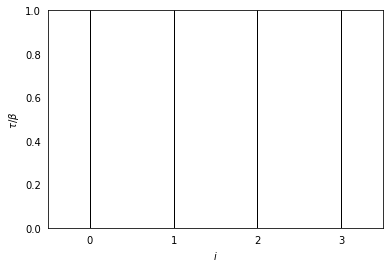

In [28]:
importlib.reload(pimc)
# Simulation parameters
t = 0
mu = 150
U = 100
L = 4
N = 4
    
# PIMC parameters
beta = 1
eta = 1      # worm end fugacity
eta = 1/np.sqrt(L*beta)

# Canonical or Grand Canonical?
canonical = False # False means Grand Canonical

# Create a random worldline configuration
alpha = pimc.random_boson_config(L,N)
alpha = [1,1,1,1]
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []
pimc.view_worldlines(data_struct,beta,figure_name=None)

### Do many iterations of the set of PIMC-WA updates

In [29]:
importlib.reload(pimc)

# Create the data structure
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []

# Store values of observables
egs_list = []
n_list = []
occ_list = []

# Set the number of times the set of updates will be attempted
mc_steps = int(1E+06)

# Counters for acceptance of each move
insert_worm_data = [0,0] # [accepted,proposed]
delete_worm_data = [0,0]

insert_anti_data = [0,0]
delete_anti_data = [0,0]

acc_timeshift = 0
prop_timeshift = 0

insertZero_worm_data = [0,0]
deleteZero_worm_data = [0,0]

insertZero_anti_data = [0,0]
deleteZero_anti_data = [0,0]

insertBeta_worm_data = [0,0]
deleteBeta_worm_data = [0,0]

insertBeta_anti_data = [0,0]
deleteBeta_anti_data = [0,0]

acc_insert_zero = 0
acc_delete_zero = 0
acc_insert_beta = 0
acc_delete_beta = 0

# Count the times the configurations has no worm ends
Z_ctr = 0
for m in range(mc_steps):
    
    # Propose all moves sequentially
    result = pimc.worm_insert(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N,insert_worm_data,insert_anti_data)

    result = pimc.worm_delete(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N,delete_worm_data,delete_anti_data)
    
    result = pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc,U,mu,canonical,N)
    if result != None:
        prop_timeshift += 1
        acc_timeshift += result
        
    result = pimc.insertZero(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N,insertZero_worm_data,insertZero_anti_data)
        
    result = pimc.deleteZero(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N,deleteZero_worm_data,deleteZero_anti_data)
        
    result = pimc.insertBeta(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N,insertBeta_worm_data,insertBeta_anti_data)
        
    result = pimc.deleteBeta(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N,deleteBeta_worm_data,deleteBeta_anti_data)

    # Calculate observables when there are no worms present
    if m >= 0.25*mc_steps and m%L==0: # Ignore unequilibrated data
        if not(pimc.check_worm(head_loc,tail_loc)):
            egs_list.append(pimc.egs_pimc(data_struct,beta,U,mu)) # <E>
            n_list.append(pimc.n_pimc(data_struct,beta)/L) # <n>
            occ_list.append(pimc.n_i_pimc(data_struct,beta))
            Z_ctr += 1

N_check:  8.0


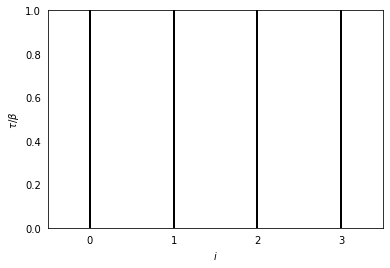

In [30]:
print("N_check: ",pimc.N_tracker(data_struct,beta))
pimc.view_worldlines(data_struct,beta,figure_name=None)

In [31]:
# Acceptance ratios
print("-------- Acceptance Ratios --------\n")

print("       Insert worm: %.4f%% (%d/%d)"%(100*insert_worm_data[0]/insert_worm_data[1],insert_worm_data[0],insert_worm_data[1]))
print("       Delete worm: %.4f%% (%d/%d)\n"%(100*delete_worm_data[0]/delete_worm_data[1],delete_worm_data[0],delete_worm_data[1]))

print("       Insert anti: %.4f%% (%d/%d)"%(100*insert_anti_data[0]/insert_anti_data[1],insert_anti_data[0],insert_anti_data[1]))
print("       Delete anti: %.4f%% (%d/%d)\n"%(100*delete_anti_data[0]/delete_anti_data[1],delete_anti_data[0],delete_anti_data[1]))

#print("         Timeshift: %.4f%% (%d)\n"%(100*acc_timeshift/prop_timeshift,prop_timeshift))

print("   InsertZero worm: %.4f%% (%d/%d)"%(100*insertZero_worm_data[0]/insertZero_worm_data[1],insertZero_worm_data[0],insertZero_worm_data[1]))
print("   DeleteZero worm: %.4f%% (%d/%d)\n"%(100*deleteZero_worm_data[0]/deleteZero_worm_data[1],deleteZero_worm_data[0],deleteZero_worm_data[1]))

print("   InsertZero anti: %.4f%% (%d/%d)"%(100*insertZero_anti_data[0]/insertZero_anti_data[1],insertZero_anti_data[0],insertZero_anti_data[1]))
print("   DeleteZero anti: %.4f%% (%d/%d)\n"%(100*deleteZero_anti_data[0]/deleteZero_anti_data[1],deleteZero_anti_data[0],deleteZero_anti_data[1]))

print("   InsertBeta worm: %.4f%% (%d/%d)"%(100*insertBeta_worm_data[0]/insertBeta_worm_data[1],insertBeta_worm_data[0],insertBeta_worm_data[1]))
print("   DeleteBeta worm: %.4f%% (%d/%d)\n"%(100*deleteBeta_worm_data[0]/deleteBeta_worm_data[1],deleteBeta_worm_data[0],deleteBeta_worm_data[1]))

print("   InsertBeta anti: %.4f%% (%d/%d)"%(100*insertBeta_anti_data[0]/insertBeta_anti_data[1],insertBeta_anti_data[0],insertBeta_anti_data[1]))
print("   DeleteBeta anti: %.4f%% (%d/%d)\n"%(100*deleteBeta_anti_data[0]/deleteBeta_anti_data[1],deleteBeta_anti_data[0],deleteBeta_anti_data[1]))

-------- Acceptance Ratios --------

       Insert worm: 8.2607% (37043/448426)
       Delete worm: 76.5211% (36737/48009)

       Insert anti: 6.6382% (29751/448176)
       Delete anti: 86.9443% (29708/34169)

   InsertZero worm: 5.6201% (27540/490024)
   DeleteZero worm: 37.0281% (27710/74835)

   InsertZero anti: 5.3053% (26073/491455)
   DeleteZero anti: 33.0788% (26247/79347)

   InsertBeta worm: 5.6592% (27762/490561)
   DeleteBeta worm: 32.8147% (26323/80217)

   InsertBeta anti: 5.3234% (26144/491116)
   DeleteBeta anti: 37.7588% (27937/73988)



N_check:  8.0


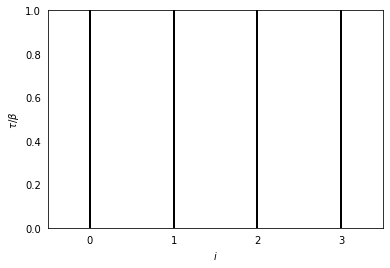

In [32]:
print("N_check: ",pimc.N_tracker(data_struct,beta))
pimc.view_worldlines(data_struct,beta,figure_name=None)

### Process data

In [33]:
egs = np.mean(egs_list)
n = np.mean(n_list)
occ = np.mean(occ_list,axis=0)
samples = len(egs_list)
print(samples)

168185


In [34]:
importlib.reload(pimc)
print("Samples: %d"%samples)
print("-------- Ground State Energy --------")
print("PIMC: %.8f"%egs)
#print("Exact: %.8f"%pimc.egs_theory(L,U,mu))
print("-------- Average particles per site --------")
print("PIMC: %.8f"%n)
print("-------- Average occupation --------")
print("PIMC:",occ)
print("-------- Z-configuration fraction --------")
print("Z-fraction: %.2f%%"%(Z_ctr/mc_steps*100))

Samples: 168185
-------- Ground State Energy --------
PIMC: -800.00000000
-------- Average particles per site --------
PIMC: 2.00000000
-------- Average occupation --------
PIMC: [2. 2. 2. 2.]
-------- Z-configuration fraction --------
Z-fraction: 16.82%


### Save data

In [35]:
egs_list = np.array(egs_list)
with open("egs_%i_%i_%.4f_%.4f_%.4f_%i.dat"%(L,N,U,mu,eta,mc_steps),"w+") as data:
    np.savetxt(data,egs_list,delimiter=",",fmt="%.16f",header="MC_step <E> // BH Parameters: L=%d,N=%d,U=%.8f,mu=%.8f,eta=%.8f,MC_steps=%i"%(L,N,U,mu,eta,mc_steps))
    
n_list = np.array(n_list)
with open("n_%i_%i_%.4f_%.4f_%.4f_%i.dat"%(L,N,U,mu,eta,mc_steps),"w+") as data:
    np.savetxt(data,n_list,delimiter=",",fmt="%.16f",header="MC_step <n> // BH Parameters: L=%d,N=%d,U=%.8f,mu=%.8f,eta=%.8f,MC_steps=%i"%(L,N,U,mu,eta,mc_steps))
    
occ_list = np.array(occ_list)
with open("occ_%i_%i_%.4f_%.4f_%.4f_%i.dat"%(L,N,U,mu,eta,mc_steps),"w+") as data:
    np.savetxt(data,occ_list,delimiter=",",fmt="%.16f",header="MC_step <n_i> // BH Parameters: L=%d,N=%d,U=%.8f,mu=%.8f,eta=%.8f,MC_steps=%i"%(L,N,U,mu,eta,mc_steps))    